In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pprint import pprint
from datetime import datetime
import os
import csv

In [2]:
yr = 2023
fire_gdf = gpd.read_file(f'../outputs/geojson/clean/ca_fire_{yr}.geojson').set_crs(4326)
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,AGENCY,FIRE_NAME,geometry
0,2023-06-17,2023-06-17,5,Debris,5.729125,CDF,WHITWORTH,"POLYGON ((-122.91148 41.53201, -122.91150 41.5..."
1,2023-06-02,2023-06-02,5,Debris,13.602380,LRA,KAISER,"POLYGON ((-121.96182 39.82970, -121.96181 39.8..."
2,2023-07-01,2023-07-02,2,Equipment Use,27.814460,CDF,JACKSON,"POLYGON ((-120.90644 38.29537, -120.90397 38.2..."
3,2023-07-11,2023-07-11,9,Miscellaneous,58.760230,CDF,CARBON,"POLYGON ((-120.98579 38.44344, -120.98488 38.4..."
4,2023-07-11,2023-07-12,14,Unknown/Unidentified,70.979000,CDF,LIBERTY,"POLYGON ((-120.98886 38.25035, -120.98895 38.2..."


In [3]:
columns_to_drop = ['FIRE_NAME', 'AGENCY', 'geometry']
fire_gdf.drop(columns=columns_to_drop, inplace=True)

In [4]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES
0,2023-06-17,2023-06-17,5,Debris,5.729125
1,2023-06-02,2023-06-02,5,Debris,13.602380
2,2023-07-01,2023-07-02,2,Equipment Use,27.814460
3,2023-07-11,2023-07-11,9,Miscellaneous,58.760230
4,2023-07-11,2023-07-12,14,Unknown/Unidentified,70.979000


In [5]:
fire_gdf['CONT_DATE'] = pd.to_datetime(fire_gdf['CONT_DATE'])
fire_gdf['ALARM_DATE'] = pd.to_datetime(fire_gdf['ALARM_DATE'])
fire_gdf['Duration'] = fire_gdf['CONT_DATE'] - fire_gdf['ALARM_DATE']

In [6]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,2023-06-17,2023-06-17,5,Debris,5.729125,0 days
1,2023-06-02,2023-06-02,5,Debris,13.602380,0 days
2,2023-07-01,2023-07-02,2,Equipment Use,27.814460,1 days
3,2023-07-11,2023-07-11,9,Miscellaneous,58.760230,0 days
4,2023-07-11,2023-07-12,14,Unknown/Unidentified,70.979000,1 days


In [7]:
fire_gdf['Duration_days'] = fire_gdf['Duration'].dt.days
fire_gdf

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration,Duration_days
0,2023-06-17,2023-06-17,5,Debris,5.729125,0 days,0
1,2023-06-02,2023-06-02,5,Debris,13.602380,0 days,0
2,2023-07-01,2023-07-02,2,Equipment Use,27.814460,1 days,1
3,2023-07-11,2023-07-11,9,Miscellaneous,58.760230,0 days,0
4,2023-07-11,2023-07-12,14,Unknown/Unidentified,70.979000,1 days,1
...,...,...,...,...,...,...,...
278,2023-08-15,2023-11-14,14,Unknown/Unidentified,550.055900,91 days,91
279,2023-08-15,2023-11-14,14,Unknown/Unidentified,378.419700,91 days,91
280,2023-08-15,2023-09-15,1,Lightning,1684.730000,31 days,31
281,2023-08-15,2023-10-25,1,Lightning,34188.450000,71 days,71


In [12]:
# Replace 'vehicle' and 'railroad' with 'transportation' in 'causes' column
df = fire_gdf['CAUSE'].replace(['Vehicle', 'Railroad'], 'Transportation')
fire_gdf['Cause'] = df
fire_gdf

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration,Cause
0,2023-06-17,2023-06-17,5,Debris,5.729125,0 days,Debris
1,2023-06-02,2023-06-02,5,Debris,13.602380,0 days,Debris
2,2023-07-01,2023-07-02,2,Equipment Use,27.814460,1 days,Equipment Use
3,2023-07-11,2023-07-11,9,Miscellaneous,58.760230,0 days,Miscellaneous
4,2023-07-11,2023-07-12,14,Unknown/Unidentified,70.979000,1 days,Unknown/Unidentified
...,...,...,...,...,...,...,...
278,2023-08-15,2023-11-14,14,Unknown/Unidentified,550.055900,91 days,Unknown/Unidentified
279,2023-08-15,2023-11-14,14,Unknown/Unidentified,378.419700,91 days,Unknown/Unidentified
280,2023-08-15,2023-09-15,1,Lightning,1684.730000,31 days,Lightning
281,2023-08-15,2023-10-25,1,Lightning,34188.450000,71 days,Lightning


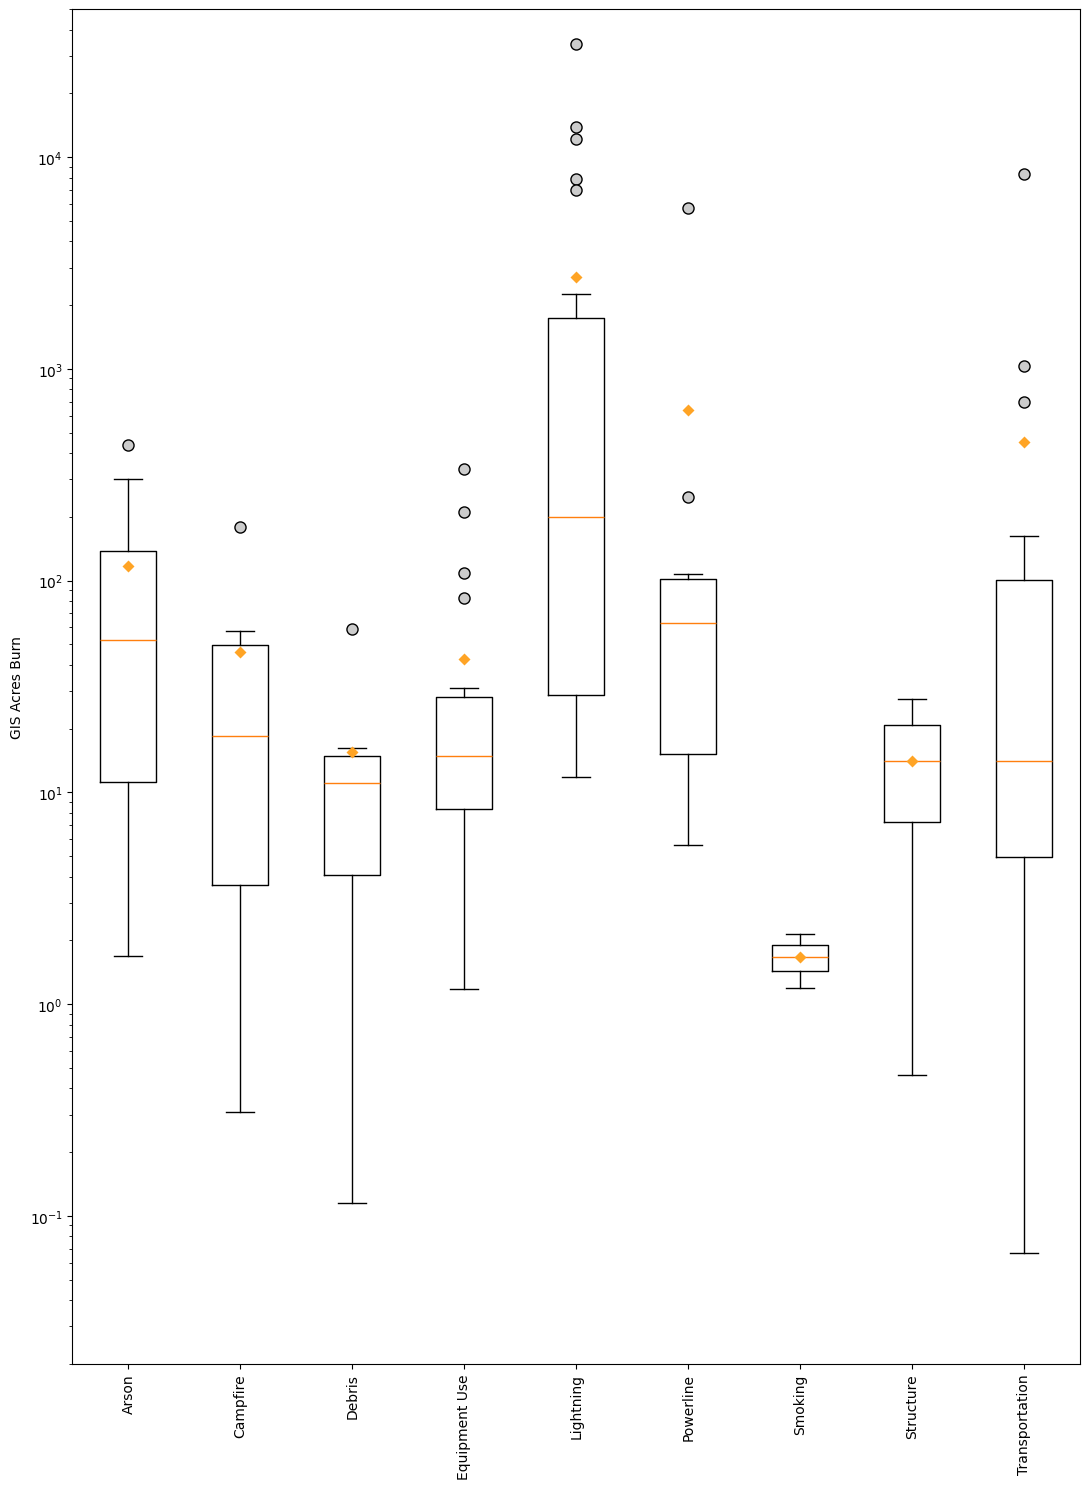

In [13]:
cause_list = fire_gdf['CAUSE'].unique()
value_to_remove = 'Miscellaneous'
new_arr = cause_list[cause_list != value_to_remove]
value_to_remove = 'Unknown/Unidentified'
cause_list = new_arr[new_arr != value_to_remove]
cause_gis = fire_gdf[fire_gdf['CAUSE'].isin(cause_list)]
grouped_data = cause_gis.groupby('CAUSE')['GIS_ACRES'].apply(list)

# # Create a box plot
# Highlight potential outliers by changing their color or style
plt.figure(figsize=(11,15))
meanprops = dict(marker='D', markeredgecolor='none',markerfacecolor='#ffa425')
plt.boxplot(grouped_data.values, tick_labels=grouped_data.index, showfliers=True, patch_artist=False, 
            flierprops=dict(marker='o', markerfacecolor='#ccc', markersize=8), meanprops = meanprops,showmeans = True
)

# Add labels and title
plt.ylim(0.02, 50000)
plt.xticks(rotation=90)
plt.ylabel('GIS Acres Burn')
plt.yscale('log')
plt.tight_layout()
plt.show()

In [40]:
average_duration = []
average_acres = []
cause_df = fire_gdf.sort_values(by='CAUSE_ID').reset_index()
def average_calc(i, df):
    test_df = df.loc[df['CAUSE_ID'] == i]
    days = []
    for d in test_df['Duration']:
        days.append(d.days)
    if len(days) != 0:
        average_d = round(sum(days)/len(days), 2)
    else:
        average_d = 0
    average_a = round(test_df['GIS_ACRES'].mean(),2)
    return average_d, average_a

for i in cause_df['CAUSE_ID'].unique():
    d, a = average_calc(i, cause_df)
    average_duration.append(d)
    average_acres.append(a)
cause_list = cause_df['CAUSE'].unique()
cause_df.head()

,index,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,282,2023-08-15,2023-09-07,1,Lightning,6953.80500,23 days
1,257,2023-08-15,2023-08-28,1,Lightning,792.96970,13 days
2,256,2023-08-16,2023-08-18,1,Lightning,14.55784,2 days
3,252,2023-08-17,2023-08-18,1,Lightning,27.64029,1 days
4,232,2023-06-17,2023-06-27,1,Lightning,46.65670,10 days


In [41]:
counts = cause_df.groupby('CAUSE_ID').size()
source_df = pd.DataFrame({'Causes' : cause_list, 
                          'Average Duration (days)' : average_duration, 
                          'Average GIS Acres' : average_acres,
                          'Number of Occurences (in the Year)' : counts})
source_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,27.64,2715.01,33
2,Equipment Use,0.79,42.62,24
3,Smoking,0.00,1.67,2
4,Campfire,1.83,45.73,6
5,Debris,0.00,15.48,7
6,Railroad,4.00,161.81,1
7,Arson,1.67,117.65,9
9,Miscellaneous,1.75,269.48,12
10,Vehicle,1.39,463.37,23


In [42]:
source_clean_df = source_df.drop(index = [9,14], inplace = False)
source_clean_df.to_csv("outputs/fire_source_2023.csv",
                  encoding="utf-8", index=False, header=True)
source_clean_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,27.64,2715.01,33
2,Equipment Use,0.79,42.62,24
3,Smoking,0.00,1.67,2
4,Campfire,1.83,45.73,6
5,Debris,0.00,15.48,7
6,Railroad,4.00,161.81,1
7,Arson,1.67,117.65,9
10,Vehicle,1.39,463.37,23
11,Powerline,1.50,637.00,10


In [43]:
man_duration = 0
man_GIS_acres = 0
man_oc = 0
nat_duration = 0
nat_GIS_acres = 0
nat_oc = 0
for index, row in source_clean_df.iterrows():
    if row['Causes'] == 'Lightning':
        nat_duration += row['Average Duration (days)']
        nat_GIS_acres += row['Average GIS Acres']
        nat_oc += row['Number of Occurences (in the Year)']
    else:
        man_duration += row['Average Duration (days)'] 
        man_GIS_acres += row['Average GIS Acres']
        man_oc += row['Number of Occurences (in the Year)']

man_vs_nature_df = pd.DataFrame({'Causes':['Man-Made', 'Natural'], 
                                 'Average Duration (days)': [man_duration, nat_duration], 
                                 'Average GIS Acres': [man_GIS_acres, nat_GIS_acres],
                                 'Number of Occurences (in the Year)':[man_oc, nat_oc]
                                })
man_vs_nature_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Man-Made,12.18,1499.36,84
1,Natural,27.64,2715.01,33


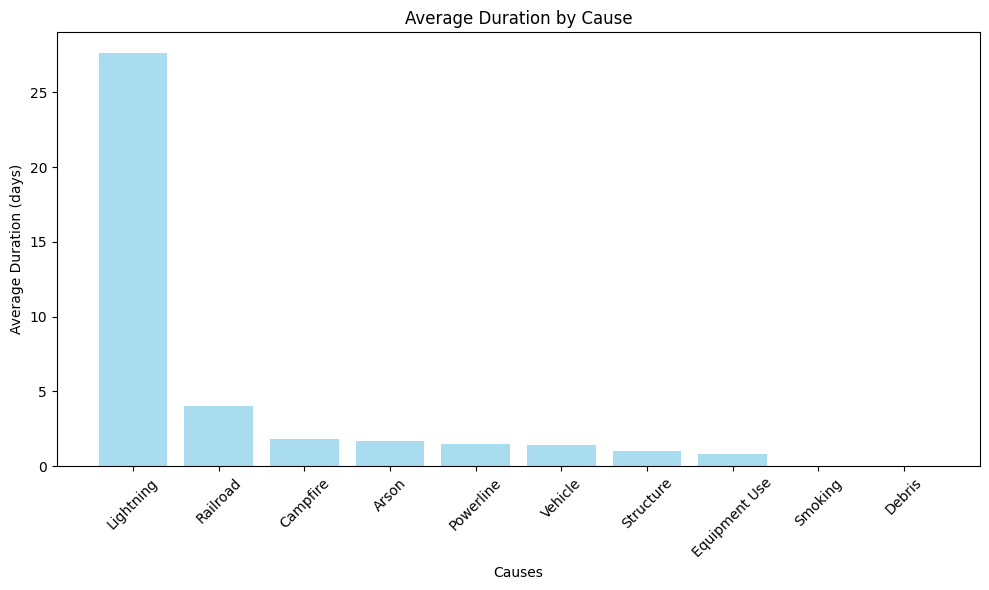

In [44]:
source_clean_df = source_clean_df.sort_values(by='Average Duration (days)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

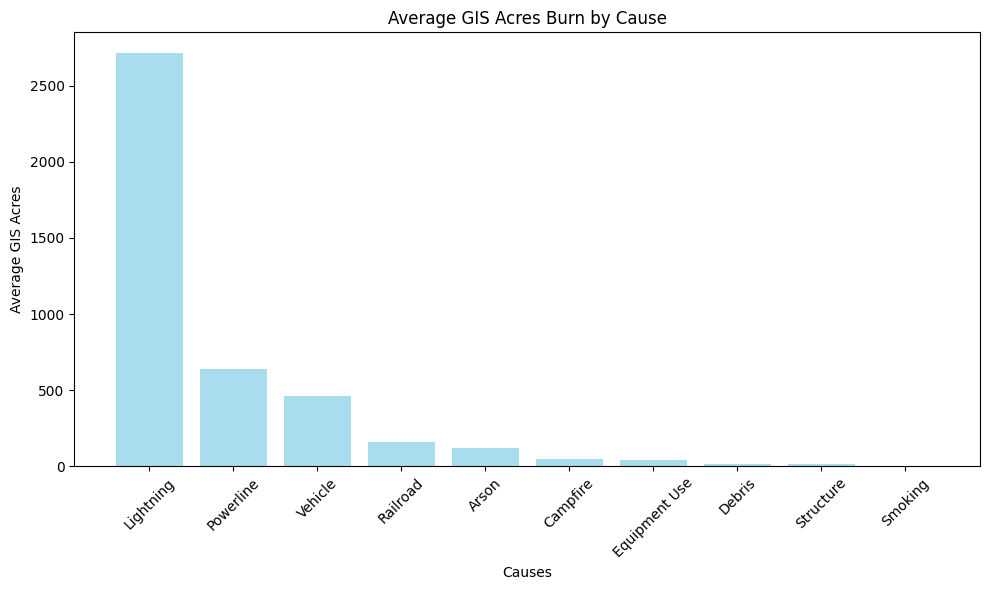

In [45]:
source_clean_df = source_clean_df.sort_values(by='Average GIS Acres', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

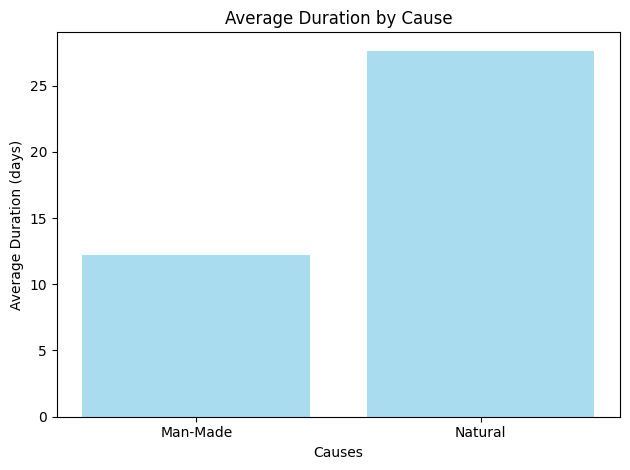

In [46]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.tight_layout()
plt.show()

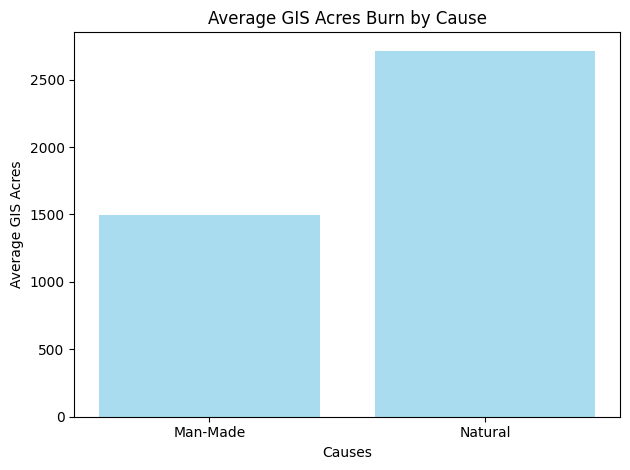

In [47]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.tight_layout()
plt.show()

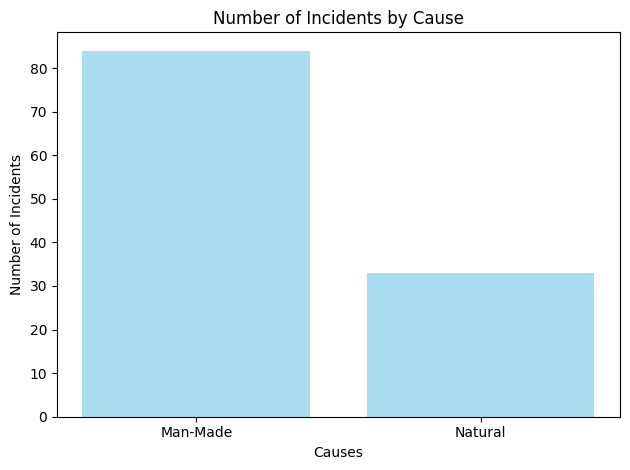

In [48]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Number of Occurences (in the Year)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.tight_layout()
plt.show()

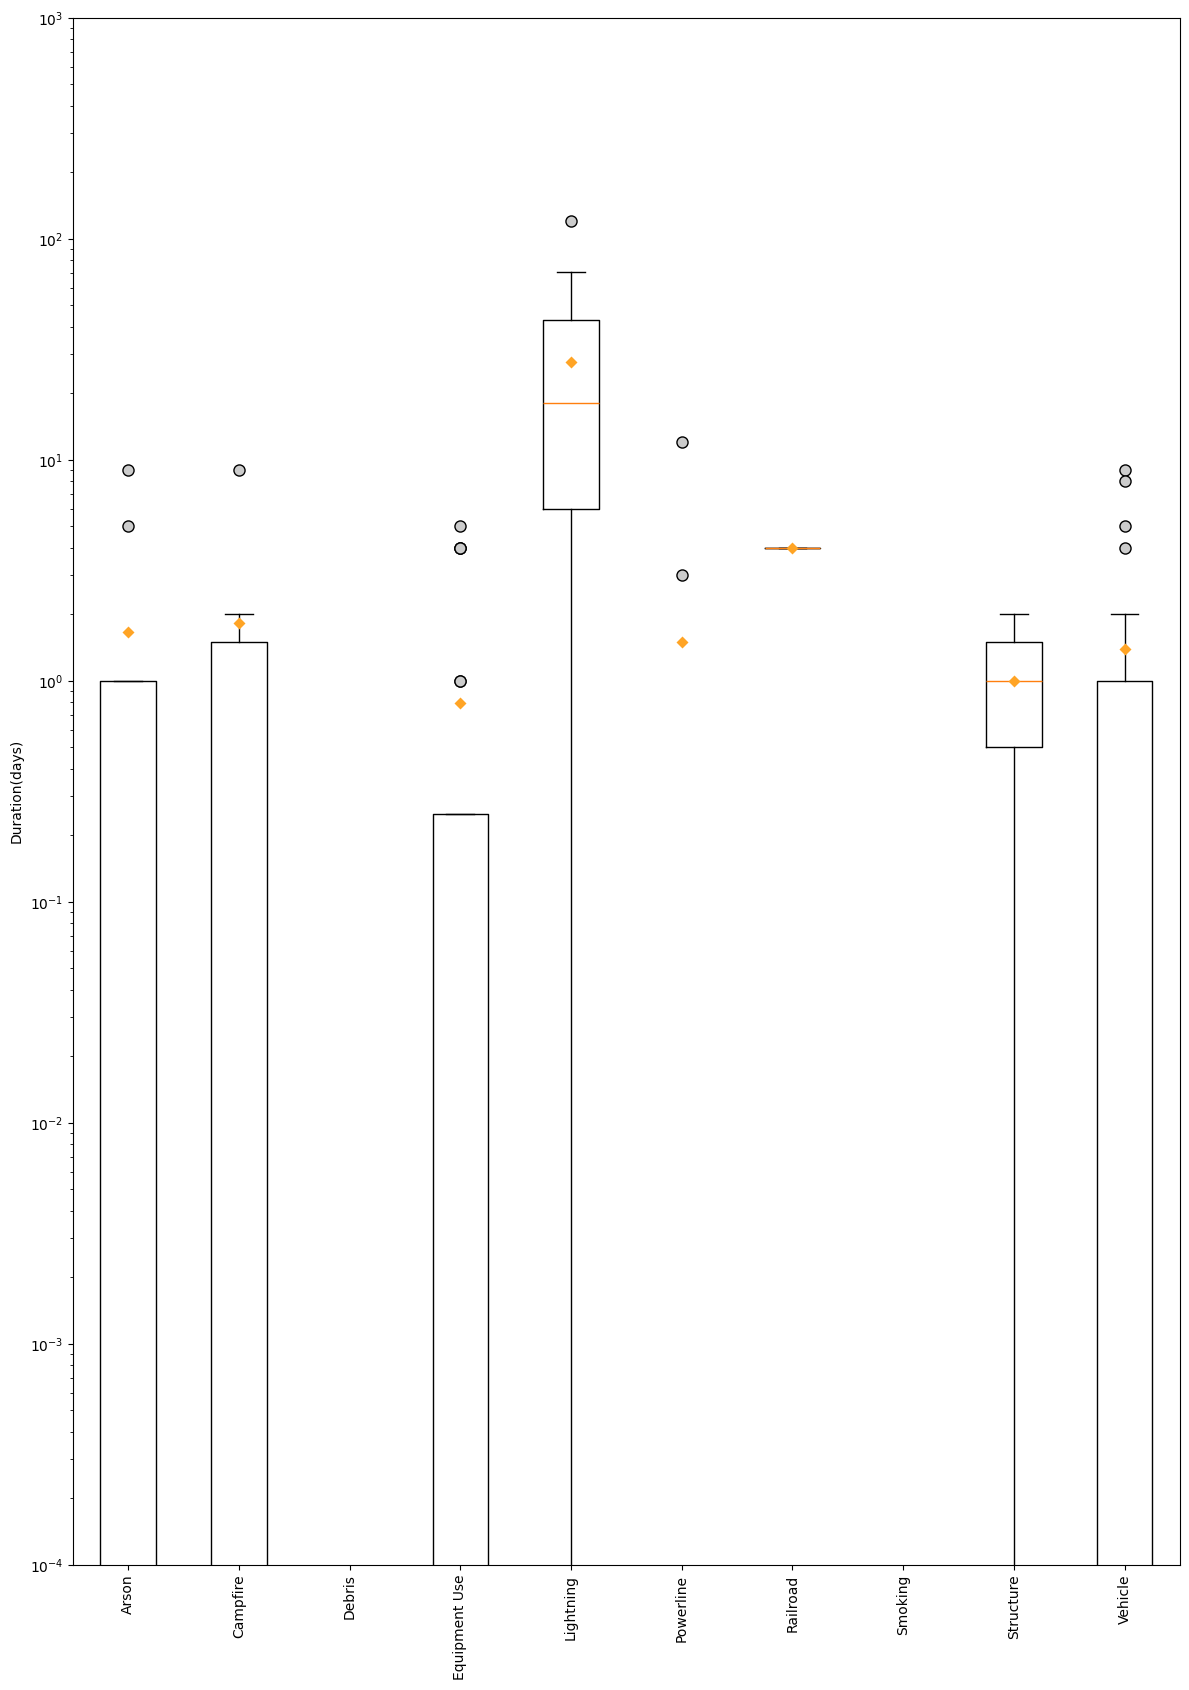

In [14]:
cause_list = fire_gdf['CAUSE'].unique()
value_to_remove = 'Miscellaneous'
new_arr = cause_list[cause_list != value_to_remove]
value_to_remove = 'Unknown/Unidentified'
cause_list = new_arr[new_arr != value_to_remove]
cause_gis = fire_gdf[fire_gdf['CAUSE'].isin(cause_list)]
grouped_data = cause_gis.groupby('CAUSE')['Duration_days'].apply(list)

# # Create a box plot
# Highlight potential outliers by changing their color or style
plt.figure(figsize=(12, 17))
meanprops = dict(marker='D', markeredgecolor='none',markerfacecolor='#ffa425')
plt.boxplot(grouped_data.values, tick_labels=grouped_data.index, showfliers=True, patch_artist=False, 
            flierprops=dict(marker='o', markerfacecolor='#ccc', markersize=8), meanprops = meanprops,showmeans = True
)

# Add labels and title
plt.ylim(0.0001, 1000)
plt.xticks(rotation=90)
plt.ylabel('Duration(days)')
plt.yscale('log')
plt.tight_layout()
plt.show()